# Sentiment analysis on Tweets
The following problem is a supervised multi-class classification problem of sentiment analysis. We will go through all the main steps of such a problem, summarized in the following table of contents:

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Preprocessing" data-toc-modified-id="Preprocessing-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Preprocessing</a></span></li><li><span><a href="#Data-Exploration" data-toc-modified-id="Data-Exploration-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Data Exploration</a></span><ul class="toc-item"><li><span><a href="#Some-statistics-on-the-dataset" data-toc-modified-id="Some-statistics-on-the-dataset-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Some statistics on the dataset</a></span></li><li><span><a href="#Sentiment-target-variable-analysis" data-toc-modified-id="Sentiment-target-variable-analysis-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Sentiment target variable analysis</a></span></li></ul></li><li><span><a href="#Feature-engineering" data-toc-modified-id="Feature-engineering-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Feature engineering</a></span><ul class="toc-item"><li><span><a href="#Number-of-words" data-toc-modified-id="Number-of-words-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Number of words</a></span></li><li><span><a href="#Counting-punctuation-(?!.)" data-toc-modified-id="Counting-punctuation-(?!.)-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Counting punctuation (?!.)</a></span></li><li><span><a href="#Emoticons" data-toc-modified-id="Emoticons-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Emoticons</a></span></li><li><span><a href="#Negation-words" data-toc-modified-id="Negation-words-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Negation words</a></span></li><li><span><a href="#Sentiment-words" data-toc-modified-id="Sentiment-words-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>Sentiment words</a></span></li><li><span><a href="#Tweet2Vec" data-toc-modified-id="Tweet2Vec-3.6"><span class="toc-item-num">3.6&nbsp;&nbsp;</span>Tweet2Vec</a></span></li></ul></li><li><span><a href="#Models" data-toc-modified-id="Models-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Models</a></span><ul class="toc-item"><li><span><a href="#Stratified-k-folds" data-toc-modified-id="Stratified-k-folds-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Stratified k-folds</a></span></li><li><span><a href="#Baseline-models" data-toc-modified-id="Baseline-models-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Baseline models</a></span><ul class="toc-item"><li><span><a href="#Always-predicting-Neutral" data-toc-modified-id="Always-predicting-Neutral-4.2.1"><span class="toc-item-num">4.2.1&nbsp;&nbsp;</span>Always predicting Neutral</a></span></li><li><span><a href="#Predicting-randomly-following-the-distribution-of-data" data-toc-modified-id="Predicting-randomly-following-the-distribution-of-data-4.2.2"><span class="toc-item-num">4.2.2&nbsp;&nbsp;</span>Predicting randomly following the distribution of data</a></span></li></ul></li><li><span><a href="#Random-Forest" data-toc-modified-id="Random-Forest-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Random Forest</a></span><ul class="toc-item"><li><span><a href="#Without-Tweet2Vec-features" data-toc-modified-id="Without-Tweet2Vec-features-4.3.1"><span class="toc-item-num">4.3.1&nbsp;&nbsp;</span>Without Tweet2Vec features</a></span></li><li><span><a href="#With-Tweet2Vec-features" data-toc-modified-id="With-Tweet2Vec-features-4.3.2"><span class="toc-item-num">4.3.2&nbsp;&nbsp;</span>With Tweet2Vec features</a></span></li></ul></li><li><span><a href="#Neural-Network" data-toc-modified-id="Neural-Network-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>Neural Network</a></span></li></ul></li><li><span><a href="#Next-steps" data-toc-modified-id="Next-steps-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Next steps</a></span></li></ul></div>

In [116]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [335]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import html
import os
import re

# Check attached .py files for more details
from emoticons import HAPPY, SAD, NEGATION
from utils import detect_lang, count_emoticons, pos_score, neg_score, check_error,\
                                        accuracy_score_per_class

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score,\
                recall_score, zero_one_loss, confusion_matrix, make_scorer
from sklearn.model_selection import StratifiedKFold, cross_val_score

from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords

from keras import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.utils.np_utils import to_categorical

import gensim

In [238]:
# Load the data
data = pd.read_csv("data/text_emotion_w_features.csv")

In [239]:
# (#rows, #columns)
data.shape

(40000, 23)

In [240]:
# Visualize first rows
data.head()

,Unnamed: 0,Unnamed: 0.1,tweet_id,sentiment,author,content,clean_content,lang,tknzd_tweet,length,...,nb_quest_marks,nb_emo_<3,nb_emo_;),nb_happy_emot,nb_sad_emot,nb_negation,pos_score,neg_score,pos_score_rel,neg_score_rel
0,0,0,1956967341,empty,xoshayzers,@tiffanylue i know i was listenin to bad habi...,@tiffanylue i know i was listenin to bad habi...,en,"['@tiffanylue', 'i', 'know', 'i', 'was', 'list...",92,...,0,0,0,0,0,1,0.457983,1.616071,0.025444,0.089782
1,1,1,1956967666,sadness,wannamama,Layin n bed with a headache ughhhh...waitin o...,layin n bed with a headache ughhhh...waitin o...,en,"['layin', 'n', 'bed', 'with', 'a', 'headache',...",60,...,0,0,0,0,0,0,0.953125,0.437500,0.073317,0.033654
2,2,2,1956967696,sadness,coolfunky,Funeral ceremony...gloomy friday...,funeral ceremony...gloomy friday...,en,"['funeral', 'ceremony', '...', 'gloomy', 'frid...",35,...,0,0,0,0,0,0,0.500000,0.541667,0.083333,0.090278
3,3,3,1956967789,enthusiasm,czareaquino,wants to hang out with friends SOON!,wants to hang out with friends soon!,en,"['wants', 'to', 'hang', 'out', 'with', 'friend...",36,...,0,0,0,0,0,0,0.062500,0.600000,0.007812,0.075000
4,4,4,1956968416,neutral,xkilljoyx,@dannycastillo We want to trade with someone w...,@dannycastillo we want to trade with someone w...,en,"['@dannycastillo', 'we', 'want', 'to', 'trade'...",86,...,0,0,0,0,0,1,0.865179,0.777679,0.050893,0.045746


## Preprocessing
In this part, we will preprocess the "content" column by **correcting/removing** some escape characters. Also, we will tokenize our tweets. In the Twitter context, a smart **tokenization** is required: we want to keep the emoticons and adapt to the Twitter "slang". Finally, we will remove **stopwords** and perform basic **stemming** on our set.

In [245]:
# Clean content column (&amp; => & | &quot; => ') and removing "ï¿½"
data["clean_content"] = data["content"].map(lambda tweet: html.unescape(tweet).replace("ï¿½", "").lower())

In [246]:
# Tokenization
tweet_tknzr = TweetTokenizer()
data["tknzd_tweet"] = data["clean_content"].map(lambda tweet: tweet_tknzr.tokenize(tweet))

In [247]:
# Removing stopwords
stop_words = stopwords.words('english')
data["tknzd_tweet_wo_sw"] = data["tknzd_tweet"].map(lambda tknzd_tweet: [word for word in tknzd_tweet if word not in stop_words])

In [248]:
# Stemming
ps_stemmer = PorterStemmer()
data["stmd_tweet"] = data["tknzd_tweet_wo_sw"].map(lambda tknzd_tweet: [ps_stemmer.stem(word) for word in tknzd_tweet])

## Data Exploration

### Some statistics on the dataset

In [249]:
sentiments = data.sentiment.unique()
authors = data.author.unique()

In [250]:
# Number of tweets, unique sentiments, and unique authors
nb_tweets = data.shape[0]
nb_sentiments = sentiments.shape[0]
nb_authors = authors.shape[0]

print("There are {0} tweets, written by {1} authors, and expressing {2} different \
sentiments.".format(nb_tweets, nb_authors, nb_sentiments))
print("The average # of tweets per author is: {:.2f}".format(nb_tweets/nb_authors))

There are 40000 tweets, written by 33871 authors, and expressing 13 different sentiments.
The average # of tweets per author is: 1.18


A feature **idea** would have been to create **dummy variables** for each author: some authors may have the tendancy to express twits in a particular sentiment register. Here, the **number of authors** is **too high** and the **#tweets/author too low** for it to be a useful variable.

In [251]:
# Compute language of each tweet
if "lang" not in data.columns:
    data["lang"] = data["clean_content"].map(lambda tweet: detect_lang(tweet))

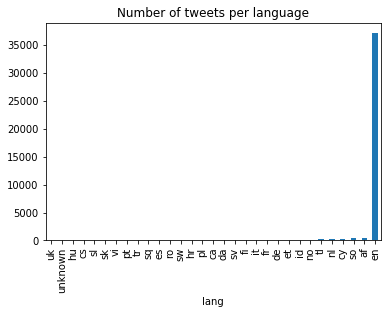

In [252]:
# Number of tweets per language
nb_tweets_per_sentiment = data.groupby("lang").count()["tweet_id"].sort_values()
nb_tweets_per_sentiment.plot(kind="bar", title="Number of tweets per language")

Seeing these numbers and for simplification, we will then consider in the following that **all tweets are in English**.

Length: min=1, max=138, avg=72.98


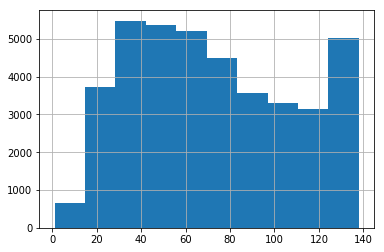

In [253]:
# Analysis of th length of tweets
data["length"] = data["clean_content"].map(lambda tweet: len(tweet))
max_length = data.length.max()
min_length = data.length.min()
avg_length = data.length.mean()
print("Length: min={0}, max={1}, avg={2:.2f}".format(min_length, max_length, avg_length))

data.length.hist()

###  Sentiment target variable analysis

In [254]:
# List of possible sentiments
print("List of possible sentiments:\n{}".format(sentiments))

List of possible sentiments:
['empty' 'sadness' 'enthusiasm' 'neutral' 'worry' 'surprise' 'love' 'fun'
 'hate' 'happiness' 'boredom' 'relief' 'anger']


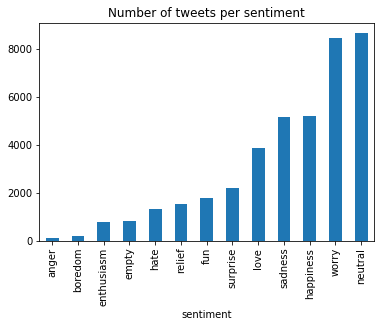

In [255]:
# Number of tweets per sentiment
nb_tweets_per_sentiment = data.groupby("sentiment").count()["tweet_id"].sort_values()
nb_tweets_per_sentiment.plot(kind="bar", title="Number of tweets per sentiment")

Multiclass (13!) classification problems are tough. Moreover, classes for this problem are strongly unbalanced. To reduce this problem, I took two initiatives :
- removing lines with "empty" label, that are in fact unlabeled tweets
- moving quasi-unexisting "anger"-labelled tweets to "hate" category

In [256]:
# Move "anger" category to "hate" category
data["sentiment"] = data["sentiment"].map(lambda sentiment: "hate" if sentiment == "anger" else sentiment)

In [257]:
# Delete empty-labelled lines
data = data[data.sentiment != "empty"].reset_index(drop=True)

## Feature engineering
In this part, we will create the features that hopefully will help us to crack the sentiment analysis problem.

Some classic features could be:
- Number of **words** in the tweet
- Punctuation: number of **exclamation marks, question marks, dots**
- Emoticons
- Number of negation words
    - Number of happy and sad emoticons
    - Number of some specific recurrent emoticons (<3, ;))
    
    
Some more advanced features: 
- **Positiveness/Negativess** of a tweet using publicly available lexicon SentiWordNet
- Tweet2Vec = aggregated Word2Vec over the words of the tweet

Additional ideas:
- *Not implemented*: use of **POS tags**, for example count of the adjectives..
- *Not implemented*: detecting **recurrent words** per sentiment for dummy variable
- *Not implemented*: bag-of-words model, mixed with TF-IDF
- *Not implemented*: for the author of the tweet, count the #number of previous messages for each sentiment

### Number of words

Nb of words: min=1, max=84, avg=15.28


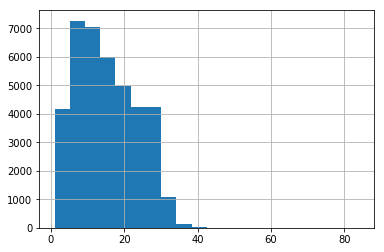

In [258]:
# Nb of words
data["nb_words"] = data["tknzd_tweet"].map(lambda list_words: len(list_words))
max_words = data.nb_words.max()
min_words = data.nb_words.min()
avg_words = data.nb_words.mean()
print("Nb of words: min={0}, max={1}, avg={2:.2f}".format(min_words, max_words, avg_words))

data.nb_words.hist(bins=20)

### Counting punctuation (?!.)

In [259]:
data["nb_dots"] = data["content"].map(lambda tweet: tweet.count("."))
data["nb_exc_marks"] = data["content"].map(lambda tweet: tweet.count("!"))
data["nb_quest_marks"] = data["content"].map(lambda tweet: tweet.count("?"))

### Emoticons
In emoticons.py file, we distinguinsh positive emoticons in "HAPPY" list, and negative emoticons in "SAD" list. Of course, taking into account our problem, it would have been better to have a more precise division of emoticons.

In [260]:
all_emot = HAPPY.union(SAD)

In [261]:
# Count # of apparitions of emoticons in all tweets and store it in a dictionnary
d_count = count_emoticons(data.tknzd_tweet, all_emot)

In [262]:
d_count

{'8)': 1,
 ":'(": 32,
 ":')": 5,
 ':-/': 10,
 ':-p': 13,
 ':@': 15,
 ':[': 7,
 ':\\': 9,
 ':]': 30,
 ':d': 3,
 ':o)': 2,
 ':p': 58,
 ':{': 1,
 ';(': 8,
 ';)': 191,
 '<3': 358,
 '=/': 13,
 '=\\': 2,
 '=]': 14,
 '=p': 14,
 'xd': 90,
 'xp': 6}

In [263]:
# For recurrent emoticons X (more than 100 occurences in dataset), 
# create a feature nb_emot_X that counts the # of X in each tweet
recurent_threshold = 100
# List of recurrent emoticons
recurent_emo = [emoticon for emoticon in d_count.keys() if d_count[emoticon]>=recurent_threshold]

data.drop([column for column in data.columns if "nb_emo" in column], axis=1, inplace=True)
# Create the columns
for emoticon in recurent_emo:
    data["nb_emo_{}".format(emoticon)] = data["tknzd_tweet"].map(lambda words: sum([1 for word in words if word == emoticon]))

In [264]:
# Count the # of positive and negative emoticons
data["nb_happy_emot"] = data["tknzd_tweet"].map(lambda words: sum([1 for word in words if word in HAPPY]))
data["nb_sad_emot"] = data["tknzd_tweet"].map(lambda words: sum([1 for word in words if word in SAD]))

### Negation words
Count the number of negation phrases (for ex., "cant", "can't", ...)

In [265]:
data["nb_negation"] = data["clean_content"].map(lambda tweet: sum([1 for neg_word in NEGATION if neg_word in tweet]))

### Sentiment words
SentiWord net is a publicly available lexicon, giving a "Positiveness" and "Negativeness" score for each word of the english vocabulary. Our goal here is to compute a pos_score and neg_score for each tweet based on that lexicon. 

The idea here is, for a given tweet, to sum the scores for each word and average.

In [266]:
sw_net = pd.read_table("data/swn.txt", skiprows=26)

In [267]:
sw_net.head()

,# POS,ID,PosScore,NegScore,SynsetTerms,Gloss
0,a,1740.0,0.125,0.00,able#1,(usually followed by `to') having the necessar...
1,a,2098.0,0.000,0.75,unable#1,(usually followed by `to') not having the nece...
2,a,2312.0,0.000,0.00,dorsal#2 abaxial#1,facing away from the axis of an organ or organ...
3,a,2527.0,0.000,0.00,ventral#2 adaxial#1,nearest to or facing toward the axis of an org...
4,a,2730.0,0.000,0.00,acroscopic#1,facing or on the side toward the apex


In [268]:
# Remove objective words (ie PosScore = 0 and NegScore = 0)
sw = sw_net[(sw_net.NegScore > 0) | (sw_net.PosScore > 0)].reset_index()
print("Number of Sentiment words: {}".format(sw.shape[0]))

Number of Sentiment words: 29095


In [269]:
# Remove "#" from SynsetTerms
sw["tknzd_synset"] = sw["SynsetTerms"].map(lambda synset: re.sub("#([0-9])*", "", synset).split())
sw.head()

,index,# POS,ID,PosScore,NegScore,SynsetTerms,Gloss,tknzd_synset
0,0,a,1740.0,0.125,0.00,able#1,(usually followed by `to') having the necessar...,[able]
1,1,a,2098.0,0.000,0.75,unable#1,(usually followed by `to') not having the nece...,[unable]
2,10,a,3700.0,0.250,0.00,dissilient#1,"bursting open with force, as do some ripe seed...",[dissilient]
3,11,a,3829.0,0.250,0.00,parturient#2,"giving birth; ""a parturient heifer""",[parturient]
4,20,a,5107.0,0.500,0.00,uncut#7 full-length#2,"complete; ""the full-length play""","[uncut, full-length]"


In [270]:
# Create usable dataframe for my computation 
word_index = []
pos_scores = []
neg_scores = []

for i, row in sw.iterrows():
    for word in row.tknzd_synset:
        word_index.append(word)
        pos_scores.append(row.PosScore)
        neg_scores.append(row.NegScore)

scores_df = pd.DataFrame(data = {"pos_score": pos_scores, "neg_score": neg_scores}, index=word_index)     
scores_df.head()

,neg_score,pos_score
able,0.00,0.125
unable,0.75,0.000
dissilient,0.00,0.250
parturient,0.00,0.250
uncut,0.00,0.500


We have formatted the lexicon in the way we wanted. We can not compute pos_score and neg_score for each tweet, and then divide by the number of words to get the average.

In [271]:
data["pos_score"] = data["stmd_tweet"].map(lambda tweet: sum([pos_score(scores_df, word) for word in tweet]))

In [272]:
data["neg_score"] = data["stmd_tweet"].map(lambda tweet: sum([neg_score(scores_df, word) for word in tweet]))

In [273]:
data["pos_score_rel"] = data["pos_score"]/data["nb_words"]
data["neg_score_rel"] = data["neg_score"]/data["nb_words"]

In the following, we check the results of our created feature, by grouping the dataset by sentiment, and computing the mean of both scores. We can notice that positive sentiments have indeed a highest positive score, which makes it a good discriminating feature (same for negative sentiments and negative score)

In [274]:
data.groupby("sentiment").mean().sort_values("pos_score_rel", ascending=False)["pos_score_rel"]

sentiment
love          0.061539
happiness     0.054945
relief        0.054343
enthusiasm    0.049409
fun           0.048912
neutral       0.044514
worry         0.044311
sadness       0.043737
surprise      0.043305
boredom       0.041301
hate          0.039683
Name: pos_score_rel, dtype: float64

In [275]:
data.groupby("sentiment").mean().sort_values("neg_score_rel", ascending=False)["neg_score_rel"]

sentiment
hate          0.048377
sadness       0.043764
worry         0.039564
boredom       0.037311
relief        0.032389
enthusiasm    0.029139
surprise      0.029129
neutral       0.028207
fun           0.028202
happiness     0.025258
love          0.022263
Name: neg_score_rel, dtype: float64

In [276]:
#data.to_csv("data/text_emotion_w_features.csv")

### Tweet2Vec

In this part, we will transform each tweet to a 200 size vector. To do that, I trained a word2vec model on my tokenized tweets which outputs a vector for each word of the vocabulary. Then, we aggregate by taking the mean of all the vectors that compose the tweet.
However, with this aggregating method, all words are considered with the same weight. In practice, all the words should not be treated equivalently, so we can weight their vector by the TF-IDF score.

In [277]:
size_embedding = 200
w2v_model = gensim.models.Word2Vec(data.tknzd_tweet, size=size_embedding)
# Dict containing (key, value)=(word, vector)
w2v = dict(zip(w2v_model.wv.index2word, w2v_model.wv.vectors))

In [486]:
# Sanity check for model performance
w2v_model.wv.most_similar("love")

[('miss', 0.8401534557342529),
 ('thank', 0.8305109143257141),
 ('loved', 0.7537878155708313),
 ('luv', 0.7375222444534302),
 ('owe', 0.7357692122459412),
 ('<3', 0.7205032110214233),
 ('appreciate', 0.7178507447242737),
 ('liked', 0.7169893980026245),
 ('missed', 0.7154136896133423),
 ('forgot', 0.7106112837791443)]

In [491]:
w2v_model.wv.most_similar("happy")

[("mother's", 0.921486496925354),
 ('mothers', 0.8986084461212158),
 ('birthday', 0.8392003774642944),
 ('wars', 0.8318478465080261),
 ('mommys', 0.8249069452285767),
 ('beautiful', 0.8083910942077637),
 ("momma's", 0.8016931414604187),
 ('belated', 0.7945509552955627),
 ("mom's", 0.7874326705932617),
 ('mommies', 0.7732957601547241)]

In [278]:
tweets2vec = []
for index, row in data.iterrows():
    nb_words = row.nb_words
    tknzd_tweet = row.tknzd_tweet
    tweet2vec = np.zeros(size_embedding)
    # Sum the vector of each word and add them. If the word is not found, we decrease the # of words
    for word in tknzd_tweet:
        try:
            tweet2vec += w2v[word]
        except KeyError:
            if nb_words > 1:
                nb_words -= 1
    # Divide by number of words
    tweet2vec /= nb_words
    tweets2vec.append(tweet2vec)

In [279]:
t2v = pd.DataFrame(tweets2vec, columns=["t2v_{}".format(i) for i in range(size_embedding)])
t2v.head()

,t2v_0,t2v_1,t2v_2,t2v_3,t2v_4,t2v_5,t2v_6,t2v_7,t2v_8,t2v_9,...,t2v_190,t2v_191,t2v_192,t2v_193,t2v_194,t2v_195,t2v_196,t2v_197,t2v_198,t2v_199
0,0.217394,0.144365,0.026492,-0.085305,-0.036387,-0.094769,0.083103,0.286269,0.087822,0.077326,...,-0.149738,0.144362,0.239027,0.166448,-0.058622,0.277699,-0.384980,0.270411,0.072929,-0.237130
1,0.068037,0.015649,-0.001767,-0.137875,0.029204,-0.139645,0.081710,0.133905,0.099852,-0.007356,...,-0.034437,0.049678,0.172862,0.109237,-0.039397,0.162186,-0.224083,0.081859,0.027599,-0.144734
2,0.481586,0.263456,-0.098936,-0.230188,-0.086499,-0.040481,-0.011437,0.314480,-0.071701,0.049454,...,0.061767,-0.009299,0.061778,0.187102,0.102376,0.272907,-0.555231,0.470309,-0.097704,-0.345757
3,0.239376,0.169543,0.036071,0.056422,-0.211502,-0.067794,0.111140,0.163457,0.056772,0.016451,...,-0.123575,-0.172463,0.349211,0.335293,0.071826,0.374123,-0.501034,0.340120,0.008684,-0.355157
4,0.313063,0.317073,0.109620,0.038170,-0.327444,-0.134137,0.008147,0.393080,0.111889,0.027864,...,-0.344380,0.102595,0.445854,0.235502,0.029792,0.205163,-0.396248,0.308946,0.016970,-0.302793


## Models
In this part, there will be 3 challenges:
1. Because of the unbalanced classes, we have to find the correct way to split between train and cross-validation set We will use **Stratified k-fold** from scikit-learn library to preserve the percentage of samples for each class.
2. We must define correctly the **metric that we want to optimize**, even more because we have a multi-class classification problem.
3. We should define some **baseline "dummy" models** to be able to quantify the improvement (or no) of the algorithm.

In [280]:
features = ["length", "pos_score_rel", "neg_score_rel"] + [column for column in data.columns if "nb_" in column]
X = data[features]
y = data.sentiment

In [484]:
# The following dictionnaries assign each sentiment to a label 
# from 0 to 10 and will be used to get from a label to the sentiment
d_sent = {}
sent_index = 0
for sentiment in y.unique():
    d_sent[sentiment] = sent_index
    sent_index += 1

inv_d_sent = {}
for sentiment in y.unique():
    inv_d_sent[d_sent[sentiment]] = sentiment
    
print("d_sent: {}".format(d_sent))
print("inv_d_sent: {}".format(inv_d_sent))

d_sent: {'sadness': 0, 'enthusiasm': 1, 'neutral': 2, 'worry': 3, 'surprise': 4, 'love': 5, 'fun': 6, 'hate': 7, 'happiness': 8, 'boredom': 9, 'relief': 10}
inv_d_sent: {0: 'sadness', 1: 'enthusiasm', 2: 'neutral', 3: 'worry', 4: 'surprise', 5: 'love', 6: 'fun', 7: 'hate', 8: 'happiness', 9: 'boredom', 10: 'relief'}


As mentionned before, we have a highly unbalanced multi-class classification problem. The following table shows the proportion of each sentiment in the dataset.

In [282]:
((data.groupby("sentiment").count()["tweet_id"]/data.shape[0]).sort_values(ascending=False))*100

sentiment
neutral       22.050902
worry         21.593955
happiness     13.297424
sadness       13.185102
love           9.807776
surprise       5.582927
fun            4.533735
relief         3.895540
hate           3.658132
enthusiasm     1.937559
boredom        0.456947
Name: tweet_id, dtype: float64

### Stratified k-folds

To be able to quantify correctly the improvements of the algorithm, we have to be able to test it over a cross-validation set. This cross-validation set should be a good representation of the entire dataset, hence random sampling is not acceptable. That is why we are usign a stratified k-fold that allow us to keep in the train and test sets the same proportion of sentiments as in the original dataset

In [319]:
skf = StratifiedKFold(4)
train, test = next(skf.split(X,y))

X_train = X.loc[train]
y_train = y[train]

X_test = X.loc[test]
y_test = y[test]

In [320]:
# To show that proportions are indeed kept
print(((pd.DataFrame(y_train).reset_index().groupby("sentiment").count()/y_train.shape[0]).sort_values(by="index", ascending=False))*100)

                index
sentiment            
neutral     22.052766
worry       21.596596
happiness   13.297021
sadness     13.184681
love         9.807660
surprise     5.582979
fun          4.534468
relief       3.894468
hate         3.656170
enthusiasm   1.937021
boredom      0.456170


### Baseline models

It is worth mentionning that the metric of quality is of high importance here due to the nature of the problem. The relevant metric to consider is strongly correlated with the business application. Here, we will keep track of the **micro and macro averages of the accuracy**, but other possibilities (precision, recall) could be accepted.

We will try 2 baseline models to be able to quantify the performance of future models.

#### Always predicting Neutral

In [464]:
# Neutral index is 3
y_true = y.map(d_sent)
y_pred = np.array([3]*data.shape[0])

In [467]:
accuracies = accuracy_score_per_class(y_true, y_pred, inv_d_sent)

Macro-average accuracy: 21.6%
Micro-average accuracy: 9.1%
#####
     sentiment  accuracy
0      sadness       0.0
1   enthusiasm       0.0
2      neutral       0.0
3        worry     100.0
4     surprise       0.0
5         love       0.0
6          fun       0.0
7         hate       0.0
8    happiness       0.0
9      boredom       0.0
10      relief       0.0


Always predicting "neutral" leads to a 22% macro-average accuracy, and is more penalized by the micro-average which considers evenly each sentiment.

In [468]:
#print("Accuracy: {:.2}".format(accuracy_score(y.map(d_sent), y_pred)))
#print("Recall: {:.2}".format(recall_score(y.map(d_sent), y_pred, average = "macro")))
#print("Precision: {:.2}".format(precision_score(y.map(d_sent), y_pred, average = "macro")))

#### Predicting randomly following the distribution of data

In [469]:
pvals = [0]*13
for sentiment in d_sent.keys():
    index = d_sent[sentiment]
    pval = data.groupby("sentiment").count()["tweet_id"][sentiment]
    pvals[index] = pval/data.shape[0]

In [470]:
y_pred = [np.argmax(draw) for draw in np.random.multinomial(1, pvals, size=data.shape[0])]

In [471]:
accuracies = accuracy_score_per_class(y_true, y_pred, inv_d_sent)

Macro-average accuracy: 14.6%
Micro-average accuracy: 9.0%
#####
     sentiment  accuracy
0      sadness      11.8
1   enthusiasm       2.2
2      neutral      21.5
3        worry      21.6
4     surprise       4.4
5         love      10.0
6          fun       4.5
7         hate       4.5
8    happiness      13.6
9      boredom       0.6
10      relief       4.6


In [472]:
#print("Accuracy: {:.2}".format(accuracy_score(y.map(d_sent), y_pred)))
#print("Recall: {:.2}".format(recall_score(y.map(d_sent), y_pred, average = "macro")))
#print("Precision: {:.2}".format(precision_score(y.map(d_sent), y_pred, average = "macro")))

### Random Forest

#### Without Tweet2Vec features

In [493]:
train, test = next(skf.split(X,y))

X_train = X.loc[train]
y_train = y[train]

X_test = X.loc[test]
y_test = y[test]

In [494]:
clf = RandomForestClassifier(n_estimators=100, max_depth=10, n_jobs=-1)

In [495]:
clf.fit(X_train, y_train)
y_true = y_test.map(d_sent).reset_index()["sentiment"]
y_pred = pd.Series(clf.predict(X_test)).map(d_sent)

In [496]:
accuracies = accuracy_score_per_class(y_true, y_pred, inv_d_sent)

Macro-average accuracy: 28.5%
Micro-average accuracy: 13.0%
#####
     sentiment  accuracy
0      sadness       1.9
1   enthusiasm       0.0
2      neutral      47.3
3        worry      66.3
4     surprise       0.4
5         love       4.6
6          fun       0.0
7         hate       0.0
8    happiness      22.8
9      boredom       0.0
10      relief       0.0


Even though the micro and macro average accuracies are improved only a bit, the algorithm seems to be more able to detect classes for which we have more data.

In [498]:
feature_importance = pd.DataFrame(clf.feature_importances_, index=X.columns, columns=["importance"]).sort_values(by="importance", ascending=False)
print(feature_importance[:10])

                importance
neg_score_rel     0.245374
pos_score_rel     0.192427
length            0.145127
nb_words          0.132593
nb_exc_marks      0.102270
nb_dots           0.059793
nb_negation       0.058053
nb_quest_marks    0.035755
nb_happy_emot     0.012388
nb_emo_<3         0.008797


Let us know that neg_score and pos_score are good features.

In [477]:
#macro_precision_scorer = make_scorer(precision_score, average="macro")
#macro_recall_scorer = make_scorer(recall_score, average="macro")
#
#accuracies = cross_val_score(clf, X, y, cv=skf.split(X,y))
#precisions = cross_val_score(clf, X, y, cv=skf.split(X,y), scoring=macro_precision_scorer)
#recalls = cross_val_score(clf, X, y, cv=skf.split(X,y), scoring=macro_recall_scorer)

In [478]:
#print("Accuracy: {:.2}".format(accuracies.mean()))
#print("Recall: {:.2}".format(recalls.mean()))
#print("Precision: {:.2}".format(precisions.mean()))

#### With Tweet2Vec features

In [479]:
X_t2v = X.join(t2v)
X_t2v.shape

(39173, 212)

In [480]:
train, test = next(skf.split(X_t2v, y))

X_train = X_t2v.loc[train]
y_train = y[train].map(d_sent)

X_test = X_t2v.loc[test]
y_test = y[test].map(d_sent)

In [481]:
clf.fit(X_train, y_train)
y_true = y_test.reset_index()["sentiment"]
y_pred = pd.Series(clf.predict(X_test))

In [482]:
accuracies = accuracy_score_per_class(y_true, y_pred, inv_d_sent)

Macro-average accuracy: 28.3%
Micro-average accuracy: 12.9%
#####
     sentiment  accuracy
0      sadness       1.4
1   enthusiasm       0.0
2      neutral      43.8
3        worry      71.2
4     surprise       0.0
5         love       6.9
6          fun       0.0
7         hate       0.0
8    happiness      18.6
9      boredom       0.0
10      relief       0.0


In [483]:
feature_importance = pd.DataFrame(clf.feature_importances_, index=X_t2v.columns, columns=["importance"]).sort_values(by="importance", ascending=False)
print(feature_importance[:10])

               importance
neg_score_rel    0.030666
t2v_83           0.019633
t2v_2            0.017413
nb_words         0.014805
pos_score_rel    0.012517
length           0.012380
t2v_13           0.011694
t2v_48           0.011186
t2v_31           0.010272
t2v_130          0.009928


In [384]:
#accuracies = cross_val_score(clf, X_t2v, y, cv=skf.split(X_t2v,y))
#precisions = cross_val_score(clf, X_t2v, y, cv=skf.split(X_t2v,y), scoring=macro_precision_scorer)
#recalls = cross_val_score(clf, X_t2v, y, cv=skf.split(X_t2v,y), scoring=macro_recall_scorer)

In [385]:
#print("Accuracy: {:.2}".format(accuracies.mean()))
#print("Recall: {:.2}".format(recalls.mean()))
#print("Precision: {:.2}".format(precisions.mean()))

### Neural Network
Neural networks intent to check if there is a significant improvement.

In [297]:
train, test = next(skf.split(X_t2v, y))

X_train = X_t2v.loc[train]
y_train = to_categorical(y[train].map(d_sent))

X_test = X_t2v.loc[test]
y_test = to_categorical(y[test].map(d_sent))

In [298]:
print("X_train shape: {}".format(X_train.shape))
print("y_train shape: {}".format(y_train.shape))
print("X_test shape: {}".format(X_test.shape))
print("y_test shape: {}".format(y_test.shape))

X_train shape: (29375, 212)
y_train shape: (29375, 11)
X_test shape: (9798, 212)
y_test shape: (9798, 11)


In [299]:
def two_hidden_layers(input_dim, output_dim, nb_n1, nb_n2, nb_n3):
    model = Sequential()
    model.add(Dense(nb_n1, input_dim=input_dim, activation="relu"))
    # Normalization layer
    model.add(BatchNormalization())
    # Prevent overfitting 
    model.add(Dropout(0.5))
    model.add(Dense(nb_n2, input_dim=input_dim, activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(nb_n2, input_dim=input_dim, activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(output_dim, activation="softmax"))

    model.compile(loss='categorical_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

    return model

In [300]:
model = two_hidden_layers(X_train.shape[1], y_train.shape[1], 100, 50, 25)
history = model.fit(X_train, y_train,
                    batch_size=126, 
                    validation_data = (X_test, y_test),
                    epochs=100, 
                    verbose=2)

Train on 29375 samples, validate on 9798 samples
Epoch 1/100
 - 1s - loss: 2.2949 - acc: 0.1942 - val_loss: 2.1127 - val_acc: 0.2424
Epoch 2/100
 - 1s - loss: 2.1215 - acc: 0.2289 - val_loss: 2.0676 - val_acc: 0.2492
Epoch 3/100
 - 1s - loss: 2.0761 - acc: 0.2466 - val_loss: 2.0593 - val_acc: 0.2588
Epoch 4/100
 - 1s - loss: 2.0481 - acc: 0.2601 - val_loss: 2.0597 - val_acc: 0.2468
Epoch 5/100
 - 1s - loss: 2.0347 - acc: 0.2683 - val_loss: 2.0585 - val_acc: 0.2511
Epoch 6/100
 - 1s - loss: 2.0207 - acc: 0.2748 - val_loss: 2.0365 - val_acc: 0.2701
Epoch 7/100
 - 1s - loss: 2.0150 - acc: 0.2769 - val_loss: 2.0289 - val_acc: 0.2672
Epoch 8/100
 - 1s - loss: 2.0055 - acc: 0.2814 - val_loss: 2.0249 - val_acc: 0.2775
Epoch 9/100
 - 1s - loss: 1.9987 - acc: 0.2863 - val_loss: 2.0216 - val_acc: 0.2694
Epoch 10/100
 - 1s - loss: 1.9912 - acc: 0.2885 - val_loss: 2.0320 - val_acc: 0.2708
Epoch 11/100
 - 1s - loss: 1.9924 - acc: 0.2881 - val_loss: 2.0372 - val_acc: 0.2617
Epoch 12/100
 - 1s - loss

Epoch 97/100
 - 1s - loss: 1.9186 - acc: 0.3193 - val_loss: 2.0160 - val_acc: 0.2863
Epoch 98/100
 - 1s - loss: 1.9150 - acc: 0.3244 - val_loss: 1.9912 - val_acc: 0.2926
Epoch 99/100
 - 1s - loss: 1.9148 - acc: 0.3253 - val_loss: 2.0138 - val_acc: 0.2890
Epoch 100/100
 - 1s - loss: 1.9165 - acc: 0.3228 - val_loss: 1.9645 - val_acc: 0.3049


The macro-average accuracy is around 29%.

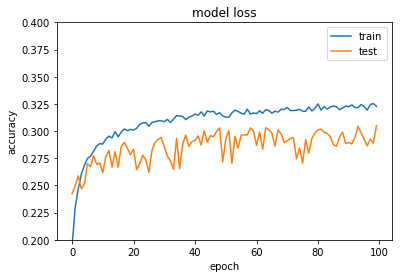

In [301]:
# Summarize history for loss
plt.plot(history.history["acc"])
plt.plot(history.history["val_acc"])
plt.title("model loss")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.ylim((0.2,0.4))
plt.legend(["train", "test"], loc="upper right")
plt.show()

## Next steps

Overall, the performance of the raw multiclass classification problem is **bad**. It is an ambitious problem that require more time to solve. However, there are some encouraging signs. 
1. Tree-based models show that pos_score and neg_score are relevant features for the problem. But there are flaws on which we can work:
    - easy: stemming as it is done makes it harder to match words of the tweet and the SentiWordNet
    - hard: it is obvious that we would like to get more granular scores (not only posive and negative, but also hate, anger..). Could be interesting to spend time on building such lexicon.
2. The model main difficulty is to detect relevant signs for rare classes. It is understandable and to fix that:
    - ideally, gather more data corresponding to rare labels
    - train model on a dataset that is constitued of evenly distributed labels
3. The word2vec aggregating part is not optimal. It could be mixed with TF-IDF to give weights to each word when averaging
    
Also, the final business application may not require as much granularity in the labels. A positive/negative/objective classification could for example be sufficient. 